### Functions:

Note: The images displayed are randomly sampled (10 from training set of each category) to play around with / visualise what is happening.

*print_category_names()* -- print names of categories in dataset

*show_category_images(category, img_type, num)* -- show 'num' images of a category

*show_category_average(category, img_type, num)* -- show average over 'num' images of a category

*get_hog(category, img_type, num)* -- get HOG features for images of a category

*get_similarity(category_1, category_2, img_type)* -- get similarity between two prototypical category representations

*get_similarity(category_1, img_type_1, category_2, img_type_2)* -- get similarity between prototypical category representations of different types i.e., photo 'cat' vs. sketch 'dog'

*get_similarity(category_1, img_type)* -- get elementwise similarity of individual members to the prototypical represenation (leaving that one out)

*similarity_map(categories, img_type, metric)* -- generate heatmap of similarities for categories in the list 'categories'


In [33]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

path = os.getcwd(); cat_path = path + '/data/sketchy/ecategories/'
# path to random experimental 10 images for each category
categories = os.listdir(cat_path)

# shows the different categories in the Sketchy dataset (categories vary for different datasets)
def print_category_names():
    print 'Length: ' + str(len(categories))
    print sorted(set(categories))

    
# show 'num' 'img_type' images for a category 'category' 
# e.g., show_category_images('cat', 'sketch', 5) or show_category_images('cat', 'photo', 10)
def show_category_images(category, img_type, num):
    assert num < 11
    assert os.path.isdir(cat_path + category)
    f = open(cat_path + category + '/' + img_type + '/filenames.txt')
    fnames = [line.strip() for line in f.readlines()[1:]]
    for fname in fnames[:num]:
        fpath = path + '/data/sketchy/efigs/' + fname
        if os.path.isfile(fpath) is False: continue
        img = Image.open(fpath)
        img = np.array(img).astype(np.uint8)
        print np.sum(img)
        print 'category: ' + str(category)
        plt.imshow(img); plt.show()
      
    
# helper function
def get_category_average(category, img_type, num):
    assert num < 11
    assert os.path.isdir(cat_path + category)
    f = open(cat_path + category + '/' + img_type + '/filenames.txt')
    fnames = [line.strip() for line in f.readlines()[1:]]
    avg = np.zeros((256, 256, 3))
    for fname in fnames[:num]:
        fpath = path + '/data/sketchy/efigs/' + fname
        if os.path.isfile(fpath) is False: continue
        img = Image.open(fpath)
        avg += np.array(img).astype(np.uint8)
    avg = np.array(avg / (1.0*num)).astype(np.uint8)
    return avg

# show average averaged over 'num' images for category 'category' 
# e.g., show_category_average('dog', 'sketch', '4')
def show_category_average(category, img_type, num):
    avg = get_category_average(category, img_type, num)
    print 'just your average ' + str(category)
    plt.imshow(avg); plt.show()
    

from sklearn.metrics.pairwise import cosine_similarity as cos_sim
from scipy.stats import spearmanr, entropy
from sklearn.metrics import log_loss, mutual_info_score
from skimage import data, io, filters, color
from PIL import ImageOps
from sklearn.decomposition import PCA
max_intensity = 255.0

def similarity_metrics(img_1, img_2):
    #plt.imshow(img_1); plt.show()
    #plt.imshow(img_2); plt.show()
    
    #img_1 = img_1.resize((16, 16)); img_2 = img_2.resize((16, 16))
    img_1, img_2 = ImageOps.invert(img_1), ImageOps.invert(img_2)
    img_1 = np.array(img_1).astype(np.uint8)
    img_2 = np.array(img_2).astype(np.uint8)
    # grayscale
    img_1 = color.rgb2gray(img_1)
    img_2 = color.rgb2gray(img_2)
    # reduce dimensions
    n_components = 3
    pca = PCA(n_components=n_components); 
    m1 = pca.fit_transform(img_1); m2 = pca.fit_transform(img_2)
    # flatten
    m1, m2 = [item for sublist in m1 for item in sublist], [item for sublist in m2 for item in sublist]
    # make intensities between 0-1
    m1, m2 = m1 / np.sum([max_intensity]), m2 /  np.sum([max_intensity])
    # normalise
    #m1, m2 = m1 / np.sum(m1), m2 / np.sum(m2)

    #plt.imshow(img_2, cmap='gray'); plt.show()
    metric_names = ['cos_sim', 'spearmanr', 'abs_diff', 'sq_diff', 'kl', 'mutual_inf']; 
    metrics = {'cos_sim': cos_sim(np.asarray([m1]), np.asarray([m2]))[0][0],
               'spearmanr': spearmanr(m1, m2)[0],
               'abs_diff': np.sum((m1.astype("float") - m2.astype("float"))),
               'sq_diff:': np.sum((m1.astype("float") - m2.astype("float")) ** 2) / float(m1.shape[0] * m2.shape[0])
    }
    return metrics

def get_similarity_1(category_1, category_2, img_type):
    avg_1 = get_category_average(category_1, img_type, 5)
    avg_2 = get_category_average(category_2, img_type, 5)
    img_1, img_2 = Image.fromarray(avg_1), Image.fromarray(avg_2)
    metrics = similarity_metrics(img_1, img_2)
    print metrics

def get_similarity_2(category_1, img_type_1, category_2, img_type_2):
    avg_1 = get_category_average(category_1, img_type_1, 5)
    avg_2 = get_category_average(category_2, img_type_2, 5)
    img_1, img_2 = Image.fromarray(avg_1), Image.fromarray(avg_2)
    metrics = similarity_metrics(img_1, img_2)
    print metrics

def get_image(category, img_type):
    assert os.path.isdir(cat_path + category)
    f = open(cat_path + category + '/' + img_type + '/filenames.txt')
    fnames = [line.strip() for line in f.readlines()[1:]]
    np.random.shuffle(fnames); fpath = path + '/data/sketchy/efigs/' + fnames[0]
    img = Image.open(fpath)
    return img

def get_similarity_3(category, img_type):
    avg = get_category_average(category, img_type, 5)
    avg = Image.fromarray(avg)
    img = get_image(category, img_type)
    metrics = similarity_metrics(img, avg)
    print metrics
  
##
import pandas
import seaborn as sns
# takes in a list of categories and generates a map of similarities
# categories = ['cat', 'dog', 'mouse', 'rabbit', 'table', 'couch', 'duck', 'swan', 'penguin', 'dolphin']
# e.g., similarity_map(categories, 'sketch', 'cos_sim')
def similarity_map(categories, img_type, metric):
    sim = np.zeros((len(categories), len(categories)))
    for i in range(len(categories)):
        for j in range(len(categories)):
            avg_1 = get_category_average(categories[i], img_type, 5)
            avg_2 = get_category_average(categories[j], img_type, 5)
            metrics = similarity_metrics(Image.fromarray(avg_1), Image.fromarray(avg_2))
            if metric not in metrics.keys(): continue
            sim[i][j] = metrics[metric]
            
    sns.set()
    df = pandas.DataFrame(sim)
    df.columns = categories; df.index = categories
    ax = sns.heatmap(df, cmap="YlGnBu", annot=True)
    ax.set_ylabel(img_type + '_' + metric)
    plt.show()
    
def test():
    img_1 = Image.open(path + '/data/sketchy/efigs/n02041246_1477-3.png'); 
    img_2 = Image.open(path + '/data/sketchy/efigs/n02041246_1477-5.png'); 
    img_3 = Image.open(path + '/data/sketchy/efigs/n02432983_20607.jpg'); 
    img_4 = Image.open(path + '/data/sketchy/efigs/n02431337_16475.jpg'); 

    metrics = similarity_metrics(img_1, img_2)
    print metrics
    metrics = similarity_metrics(img_1, img_3)
    print metrics
    metrics = similarity_metrics(img_4, img_3)
    print metrics
 


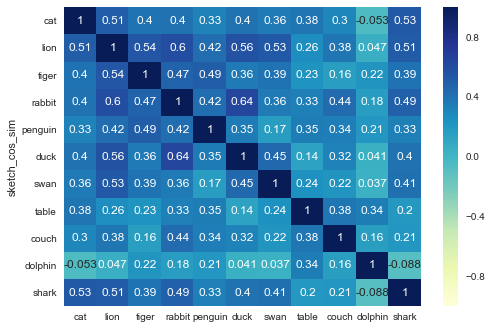

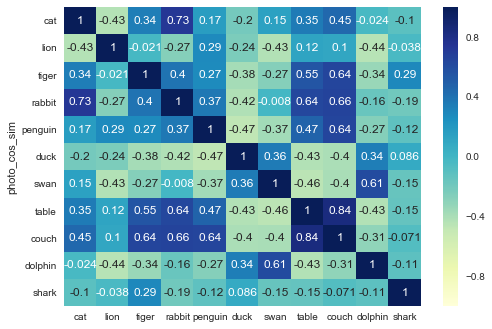

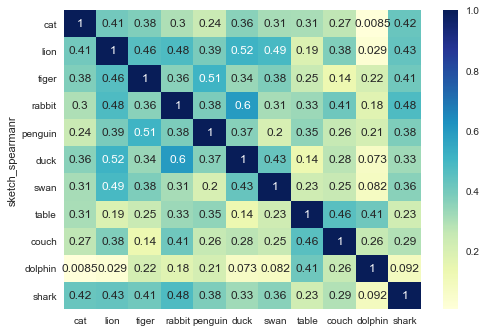

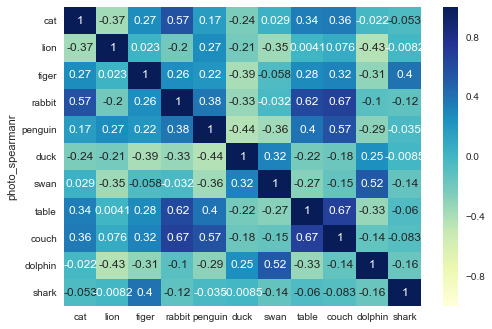

"\nget_similarity_3('motorcycle', 'sketch')\nget_similarity_2('motorcycle', 'photo', 'motorcycle', 'sketch')\nget_similarity_2('bicycle', 'photo', 'bicycle', 'sketch')\nget_similarity_2('bicycle', 'photo', 'motorcycle', 'photo')\n"

In [38]:
categories = ['cat', 'lion', 'tiger', 'rabbit', 'penguin', 'duck', 'swan', 'table', 'couch', 'dolphin', 'shark']
#categories = ['cat', 'lion', 'rabbit', 'table']


#np.random.shuffle(categories); cats = categories[:10]
similarity_map(categories, 'sketch', 'cos_sim')
similarity_map(categories, 'photo', 'cos_sim')

similarity_map(categories, 'sketch', 'spearmanr')
similarity_map(categories, 'photo', 'spearmanr')


'''
get_similarity_3('motorcycle', 'sketch')
get_similarity_2('motorcycle', 'photo', 'motorcycle', 'sketch')
get_similarity_2('bicycle', 'photo', 'bicycle', 'sketch')
get_similarity_2('bicycle', 'photo', 'motorcycle', 'photo')
'''

27516845
category: airplane


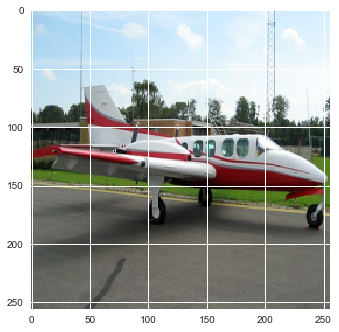

26068893
category: airplane


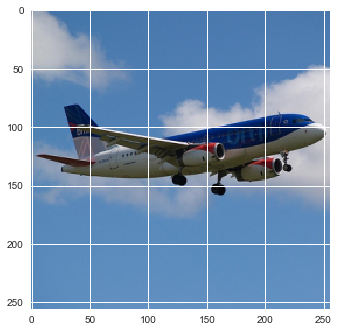

just your average airplane


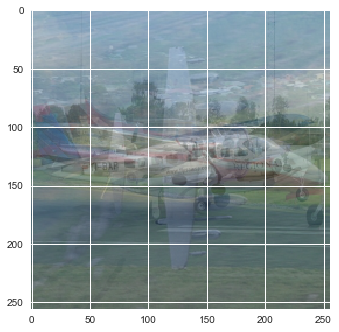

49048416
category: bicycle


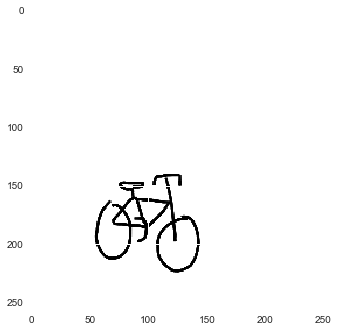

48353073
category: bicycle


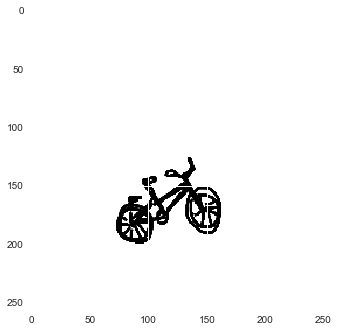

just your average bicycle


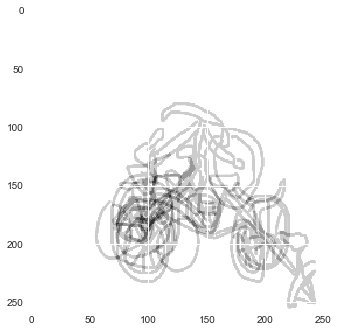

31440934
category: wine_bottle


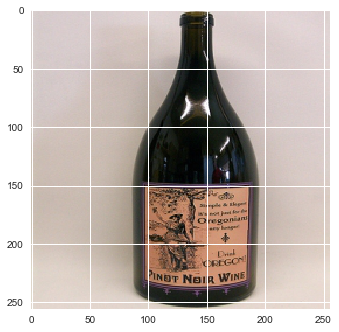

30345675
category: wine_bottle


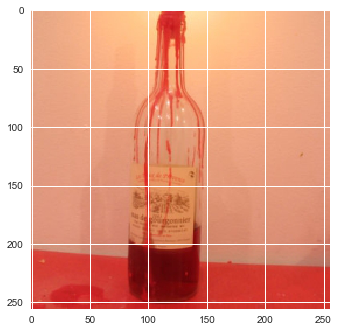

just your average wine_bottle


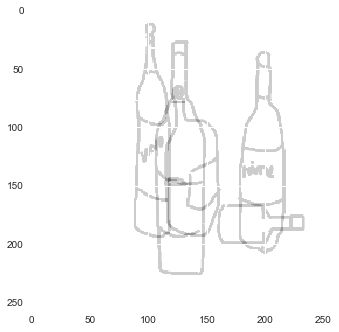

just your average dog


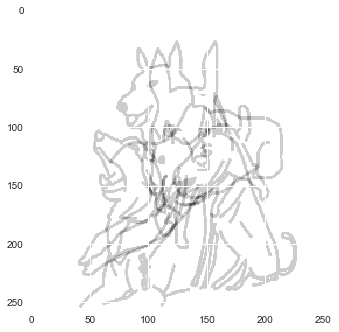

In [53]:
show_category_images('airplane', 'photo', 2)
show_category_average('airplane', 'photo', 5)
show_category_images('bicycle', 'sketch', 2)
show_category_average('bicycle', 'sketch', 5)

show_category_images('wine_bottle', 'photo', 2)
show_category_average('wine_bottle', 'sketch', 5)
show_category_average('dog', 'sketch', 5)

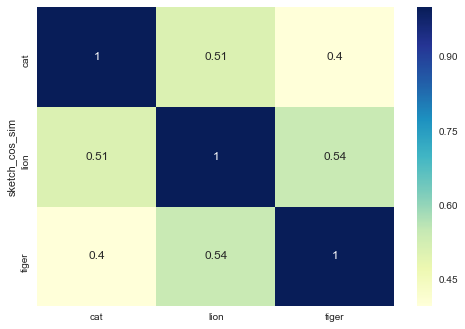

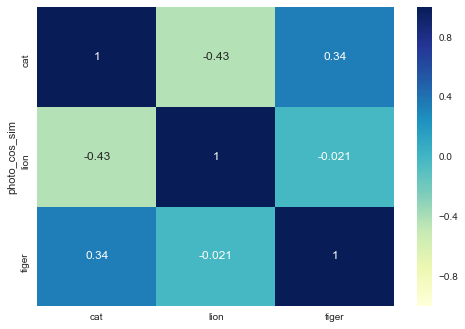

In [36]:
categories = ['cat', 'lion', 'tiger']
#np.random.shuffle(categories); cats = categories[:10]
similarity_map(categories, 'sketch', 'cos_sim')
similarity_map(categories, 'photo', 'cos_sim')

In [37]:
from sklearn.decomposition import PCA 
import numpy as np
from PIL import Image
import os
from skimage import data, io, filters, color
def testing():
    a = [[9, 1, 2], [1, 4, 6], [3, 8, 1]]
    print a
    print np.shape(a)
    pca = PCA(n_components=2); X = pca.fit_transform(a)
    print X
    path = os.getcwd()
    img_1 = Image.open(path + '/data/sketchy/efigs/n02041246_1477-3.png'); 
    
    img_1 = np.array(img_1).astype(np.uint8); img_1 = color.rgb2gray(img_1)
    print np.shape(img_1)
    pca = PCA(n_components=2);
    X = pca.fit_transform(img_1); print np.shape(X)
    
testing()

[[9, 1, 2], [1, 4, 6], [3, 8, 1]]
(3, 3)
[[ 5.8202174  -0.11814508]
 [-3.06402961 -3.29149582]
 [-2.75618779  3.4096409 ]]
(256, 256)
(256, 2)


~ stray notes

At the end of whatever training procedure, we want a representation for each category.

Possible different representations:
    
1. Averaging pixels (representation = matrix of pixel intensity values, either RGB or gray)
2. Training a CNN with objective to predict a label (representation = last hidden layer)
3. Training an AE with objective to reconstruct image (representation = hidden layer beforere constructing)
4. Training an AE with objective to both reconstruct image and classify original/hidden representation (representation = hidden layer)
5. Training a bimodal AE with objective to reconstruct image, reconstruct text (representation = fused hidden layer of both modes)
6. Training a bimodal AE with obejctive to both reconstruct image, reconstruct text and classify fused latent represetnation (representation = hidden layer)

Take away from results i.e., if (1) works (is highly correlated with human ratings) what does this mean?
1. Raw pixels of images are enough to provide semantic information.
2. CNN features (convolving over pixels) provide semantic information.
3. Unsupervised AE features (condensing into lower dimensions i.e., getting abstract representation)
4. Semi supervised AE features (abstracting and also classifying raw pixels)
5. Bimodal AE (fusing visual and textual information and getting combined abstract representation) provides semantic information
6. Bimodal AE(get combined abstract and also classify)